In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [4]:
from google.colab import drive
drive.mount("./gdrive")
!unzip "/content/gdrive/My Drive/Assignment 5 Dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Assignment 5 Dataset/train/normal/7ec0b033-9133-4f8c-abd0-ea246aa21dfa.png  
  inflating: Assignment 5 Dataset/train/normal/7ec4666c-0304-4b7b-8263-bf417ab7cccd.png  
  inflating: Assignment 5 Dataset/train/normal/7ee9ace4-3059-49c4-9356-705203289e46.png  
  inflating: Assignment 5 Dataset/train/normal/7ef283b8-9c5a-4ada-a575-f68289e338ae.png  
  inflating: Assignment 5 Dataset/train/normal/7ef98cac-f239-406e-af10-67aead1e038f.png  
  inflating: Assignment 5 Dataset/train/normal/7efb172c-23b7-4d57-bd57-bd461b9e7ca7.png  
  inflating: Assignment 5 Dataset/train/normal/7f015127-0907-4ba7-8021-cf868a210d4c.png  
  inflating: Assignment 5 Dataset/train/normal/7f05b70f-2ad0-4db6-9e05-6c2baec8cd52.png  
  inflating: Assignment 5 Dataset/train/normal/7f11cf49-7b97-4d39-82a1-18411a4599cd.png  
  inflating: Assignment 5 Dataset/train/normal/7f12966e-c382-4f9e-90ac-e1575dcdc812.png  
  inflating: Assignment 5 Dataset/train/normal/7f

In [0]:
data_dir = './Assignment 5 Dataset'

In [45]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)
val_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=10, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)
valloader = torch.utils.data.DataLoader(val_data, batch_size=10, shuffle=True)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


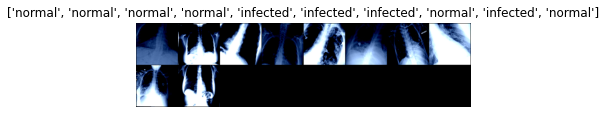

In [46]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)

In [5]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
print(vgg16)
print('Output Layer of VGG16 : ', vgg16.classifier[6].out_features) # 1000 

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [6]:
print(vgg16.classifier[3])

Linear(in_features=4096, out_features=4096, bias=True)


In [0]:
#Task 1
for param in vgg16.features.parameters():
    param.requires_grad = False

In [0]:
#Task 2.1
i=0
for param in vgg16.features.parameters():
    if(i<=12):
      param.requires_grad = False
    else:
      param.requires_grad = True
    i+=1

In [0]:
#Task 2.2
for param in vgg16.features.parameters():
    param.requires_grad = True

In [8]:
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-3] # Remove last 3 layers
features[0].out_features = (5*10)+100
features[3].in_features = features[0].out_features
features[3].out_features = len(class_names)
print(features)

[Linear(in_features=25088, out_features=150, bias=True), ReLU(inplace=True), Dropout(p=0.5, inplace=False), Linear(in_features=150, out_features=2, bias=True)]


In [9]:
vgg16.classifier = nn.Sequential(*features)
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.parameters(), lr=0.0001, momentum=0.9)

In [11]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

vgg16.train()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [0]:
loss_values = []
acc_values = []

In [0]:
#Task 1
vgg16.load_state_dict(torch.load('vgg16_FC_Only.pth'))

In [19]:
#Task 2
vgg16.load_state_dict(torch.load('vgg16_entire.pth'))

<All keys matched successfully>

In [13]:
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = vgg16(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    loss_values.append(running_loss / len(trainloader))
    print('Loss:', running_loss / len(trainloader))

    dataiter = iter(valloader)
    images, lbls = dataiter.next()
    images, lbls = images.to(device), lbls.to(device) #-->convert validation image to cuda (if available)
    outs = vgg16(images)                               #--> forward pass
    _, predicted = torch.max(outs, 1) 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, lbls = data
            images, lbls = images.to(device), lbls.to(device)
            outs = vgg16(images)
            _, predicted = torch.max(outs.data, 1)
            total += lbls.size(0)
            correct += (predicted == lbls).sum().item()

    acc = 100 * correct / total
    print('Accuracy: %f %%' % (acc))

    acc_values.append(acc)

    #torch.save(vgg16.state_dict(), 'vgg16_FC_Only.pth')
    torch.save(vgg16.state_dict(), 'vgg16_entire.pth')

print('Finished Training')

Train Epoch: 0 [11990/12000 (100%)]	Loss: 0.530956: : 1200it [13:34,  1.47it/s]


Loss: 0.44775143490017705
Accuracy: 85.400000 %


Train Epoch: 1 [11990/12000 (100%)]	Loss: 0.222259: : 1200it [13:31,  1.48it/s]


Loss: 0.29376245645961413
Accuracy: 89.066667 %


Train Epoch: 2 [11990/12000 (100%)]	Loss: 0.030832: : 1200it [13:29,  1.48it/s]


Loss: 0.2621690816401194
Accuracy: 89.533333 %


Train Epoch: 3 [11990/12000 (100%)]	Loss: 0.246735: : 1200it [13:32,  1.48it/s]


Loss: 0.2383109893820559
Accuracy: 90.000000 %


Train Epoch: 4 [11990/12000 (100%)]	Loss: 0.612243: : 1200it [13:33,  1.48it/s]


Loss: 0.23314128693309613
Accuracy: 91.066667 %


Train Epoch: 5 [11990/12000 (100%)]	Loss: 0.131394: : 1200it [13:28,  1.48it/s]


Loss: 0.23363204365518564
Accuracy: 90.800000 %


Train Epoch: 6 [2140/12000 (18%)]	Loss: 0.503839: : 215it [02:25,  1.45it/s]

KeyboardInterrupt: ignored

Loss Curve


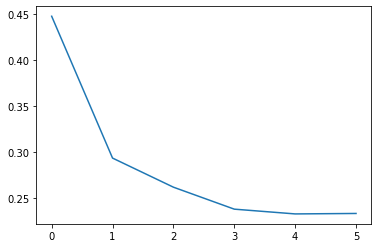

In [14]:
print('Loss Curve')
plt.plot(loss_values)

Accuracy Curve


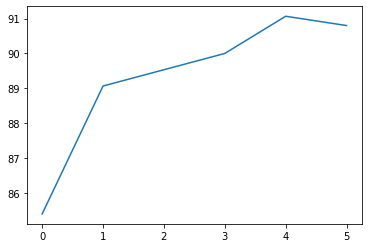

In [15]:
print('Accuracy Curve')
plt.plot(acc_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


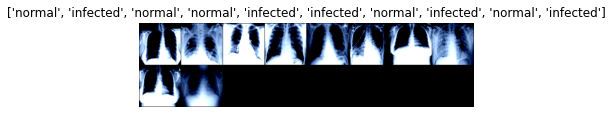

In [16]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [20]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = vgg16(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  infected infected normal normal normal infected normal normal normal normal
Ground Truth:  infected infected normal normal normal normal normal normal normal normal


In [35]:
correct = 0
total = 0
test_set = []
test_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_set.append(labels)
        test_preds.append(predicted)
        
test_set = torch.cat(test_set)
test_preds = torch.cat(test_preds)
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 96.400000 %


In [0]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [0]:
cm = confusion_matrix(test_set.cpu(), test_preds.cpu())

Confusion matrix, without normalization
[[568  47]
 [  7 878]]


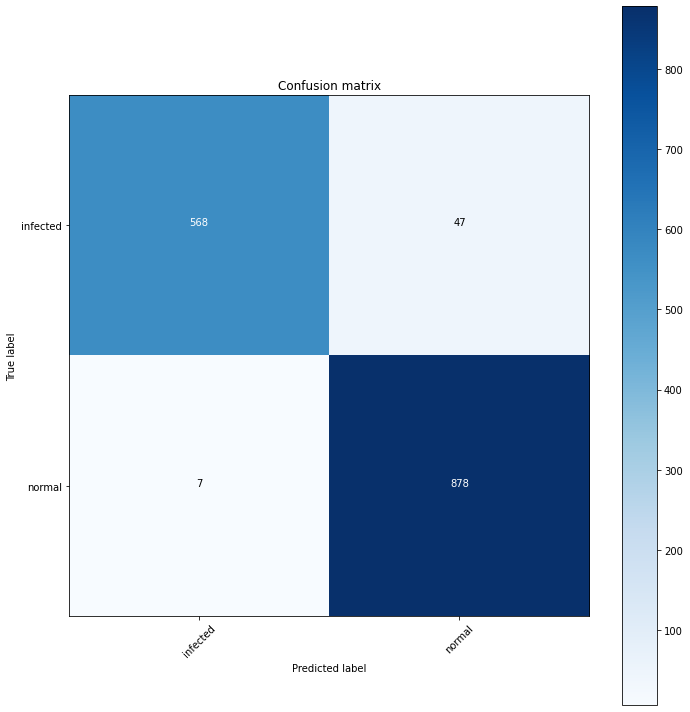

In [42]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, class_names)

In [47]:
# Load the pretrained model from pytorch
resnet18 = models.resnet18(pretrained=True)
print(resnet18)
print('Output Layer of ResNet18 : ', resnet18.fc.out_features) # 1000 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [0]:
#Task 1
for param in resnet18.parameters():
    param.requires_grad = False

In [0]:
#Task 2.1
i=0
for param in resnet18.parameters():
    if(i<=30):
      param.requires_grad = False
    else:
      param.requires_grad = True
    i+=1

In [0]:
#Task 2.2
for param in resnet18.parameters():
    param.requires_grad = True

In [49]:
num_features = resnet18.fc.in_features
resnet18.fc = nn.Sequential(nn.Linear(num_features, 150), nn.ReLU(inplace=True), nn.Dropout(), nn.Linear(150, len(class_names)))
print(resnet18.fc)

Sequential(
  (0): Linear(in_features=512, out_features=150, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=150, out_features=2, bias=True)
)


In [50]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.0001, momentum=0.9)

In [52]:
from tqdm import tqdm

#if you have gpu then you need to convert the network and data to cuda
#the easiest way is to first check for device and then convert network and data to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

resnet18.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [0]:
loss_values = []
acc_values = []

In [0]:
#Task 1
resnet18.load_state_dict(torch.load('res18_FC_Only.pth'))

<All keys matched successfully>

In [54]:
#Task 2
resnet18.load_state_dict(torch.load('res18_entire.pth'))

<All keys matched successfully>

In [55]:
for epoch in range(Epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader))
    for i, data in pbar:
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()
        # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
        # because PyTorch accumulates the gradients on subsequent backward passes. 
        # This is convenient while training RNNs. 
        # So, the default action is to accumulate the gradients on every loss.backward() call

        # forward + backward + optimize
        outputs = resnet18(inputs)               #----> forward pass
        loss = criterion(outputs, labels)   #----> compute loss
        loss.backward()                     #----> backward pass
        optimizer.step()                    #----> weights update

        # print statistics
        running_loss += loss.item()
        
        pbar.set_description(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, i * len(inputs), len(trainloader.dataset),
                100. * i / len(trainloader),
                loss.item()))
        
    loss_values.append(running_loss / len(trainloader))
    print('Loss:', running_loss / len(trainloader))
    
    dataiter = iter(valloader)
    images, lbls = dataiter.next()
    images, lbls = images.to(device), lbls.to(device) #-->convert validation image to cuda (if available)
    outs = resnet18(images)                               #--> forward pass
    _, predicted = torch.max(outs, 1) 
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, lbls = data
            images, lbls = images.to(device), lbls.to(device)
            outs = resnet18(images)
            _, predicted = torch.max(outs.data, 1)
            total += lbls.size(0)
            correct += (predicted == lbls).sum().item()

    acc = 100 * correct / total
    print('Accuracy: %f %%' % (acc))

    acc_values.append(acc)

    #torch.save(resnet18.state_dict(), 'res18_FC_Only.pth')
    torch.save(resnet18.state_dict(), 'res18_entire.pth')

print('Finished Training')


0it [00:00, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.079758: : 0it [00:00, ?it/s]
Train Epoch: 0 [0/12000 (0%)]	Loss: 0.079758: : 1it [00:00,  2.68it/s]
Train Epoch: 0 [10/12000 (0%)]	Loss: 0.117089: : 1it [00:00,  2.68it/s]
Train Epoch: 0 [10/12000 (0%)]	Loss: 0.117089: : 2it [00:00,  2.73it/s]
Train Epoch: 0 [20/12000 (0%)]	Loss: 0.178136: : 2it [00:01,  2.73it/s]
Train Epoch: 0 [20/12000 (0%)]	Loss: 0.178136: : 3it [00:01,  2.78it/s]
Train Epoch: 0 [30/12000 (0%)]	Loss: 0.405491: : 3it [00:01,  2.78it/s]
Train Epoch: 0 [30/12000 (0%)]	Loss: 0.405491: : 4it [00:01,  2.85it/s]
Train Epoch: 0 [40/12000 (0%)]	Loss: 0.294905: : 4it [00:01,  2.85it/s]
Train Epoch: 0 [40/12000 (0%)]	Loss: 0.294905: : 5it [00:01,  2.94it/s]
Train Epoch: 0 [50/12000 (0%)]	Loss: 0.243091: : 5it [00:02,  2.94it/s]
Train Epoch: 0 [50/12000 (0%)]	Loss: 0.243091: : 6it [00:02,  2.99it/s]
Train Epoch: 0 [60/12000 (0%)]	Loss: 0.313115: : 6it [00:02,  2.99it/s]
Train Epoch: 0 [60/12000 (0%)]	Loss: 0.313115: : 7

KeyboardInterrupt: ignored

Loss Curve


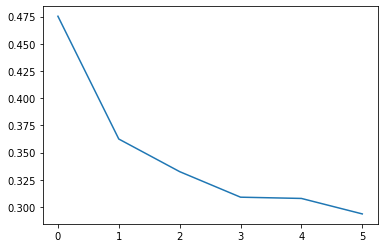

In [0]:
print('Loss Curve')
plt.plot(loss_values)

Accuracy Curve


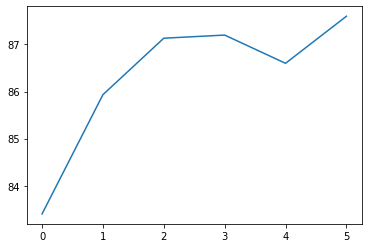

In [0]:
print('Accuracy Curve')
plt.plot(acc_values)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


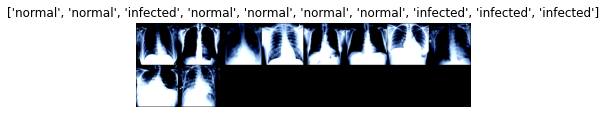

In [56]:
dataiter = iter(testloader)
images, labels = dataiter.next()
show_databatch(images, labels)

In [57]:
images, labels = images.to(device), labels.to(device) #-->convert test image to cuda (if available)
outputs = resnet18(images)                               #--> forward pass
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % class_names[predicted[j]]
                              for j in range(len(images))))
print('Ground Truth: ', ' '.join('%5s' % class_names[labels[j]]
                              for j in range(len(images))))

Predicted:  normal normal infected normal normal normal normal infected infected infected
Ground Truth:  normal normal infected normal normal normal normal infected infected infected


In [58]:
correct = 0
total = 0
test_set = []
test_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = resnet18(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        test_set.append(labels)
        test_preds.append(predicted)
        
test_set = torch.cat(test_set)
test_preds = torch.cat(test_preds)
print('Accuracy of the network on the 10000 test images: %f %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 92.000000 %


In [0]:
cm = confusion_matrix(test_set.cpu(), test_preds.cpu())

Confusion matrix, without normalization
[[543  72]
 [ 48 837]]


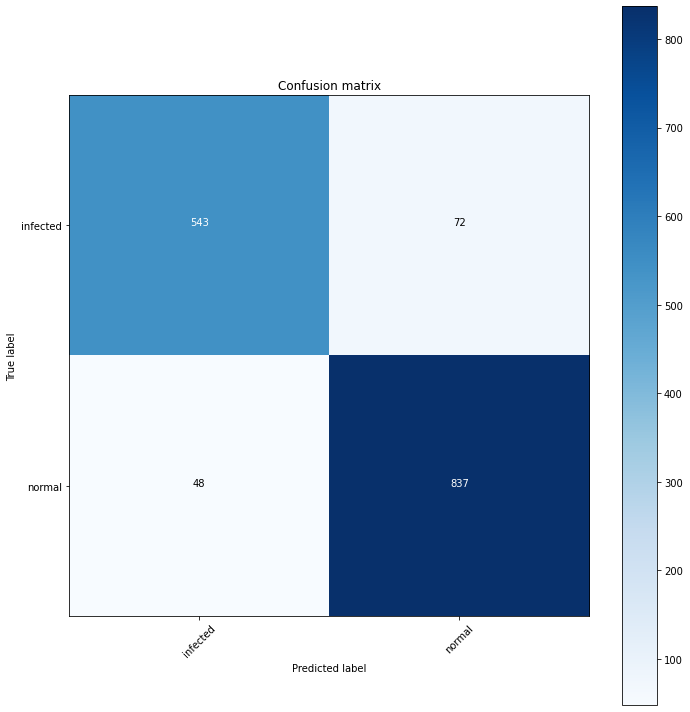

In [60]:
plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, class_names)